In [104]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from rl4co.envs import SLAPEnv, RL4COEnvBase
from rl4co.envs.warehousing.slap.generator import SLAPGenerator
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.ops import gather_by_index


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
class SLAPInitEmbedding(nn.Module):
    """Initial embedding 
    Embed the following node features to the embedding space:
        - locs: x, y coordinates of the nodes (cells)
        - probe: index of the (single) probe cell. We embed the euclidean distance from the probe to all cells.
    """

    def __init__(self, embed_dim, linear_bias=True):
        super(SLAPInitEmbedding, self).__init__()
        node_dim = 1  # x, y, dist_depot
        self.init_embed = nn.Linear(node_dim, embed_dim, linear_bias)  # locs
        # self.init_freq = nn.Linear(1, embed_dim, linear_bias)
        self.init_embed_depot = nn.Linear(2, embed_dim, linear_bias)

    def __forwards(self, td):
        # node_embeddings = self.init_embed(td["locs"])
        # node_embeddings = self.init_embed(td["locs"])     
        depot = td["locs"][:, :1, :]
        storage_locs = td["locs"][:, 1:, :]
        dist_mat = self._get_distance_matrix(td["locs"])
        depot_idx = 0
        depot_to_all_distances = dist_mat[:,depot_idx, :]
        depot_to_all_distances = torch.cat([
            depot_to_all_distances[:, :depot_idx],  # Distances before depot index
            depot_to_all_distances[:, depot_idx + 1:]
        ], dim=1)
        node_embeddings = self.init_embed(
            torch.cat((storage_locs, depot_to_all_distances[..., None]), -1)
        )
        depot_embedding = self.init_embed_depot(depot)
        out = torch.cat((depot_embedding, node_embeddings), -2)
        return out
    
    def _forward(self, td):
        dist_mat = self._get_distance_matrix(td["locs"])
        depot_idx = 0
        depot_to_all_distances = dist_mat[:,depot_idx, :]
        node_embeddings = self.init_embed(
            torch.cat((td["locs"], depot_to_all_distances[..., None]), -1)
        )
        print(node_embeddings.shape)
        return node_embeddings
    
    def forward(self, td):
        dist_mat = self._get_distance_matrix(td["locs"])
        depot_idx = 0
        depot_to_all_distances = dist_mat[:,depot_idx, :]
        node_embeddings = self.init_embed(depot_to_all_distances[..., None])
        return node_embeddings
    
    def _distance_depot(self, locs, depot):
        pass
        
    @staticmethod
    def _get_distance_matrix(locs: torch.Tensor):
        """Compute the Manhattan distance matrix for the given coordinates.

        Args:
            locs: Tensor of shape [..., n, dim]
        """
        if locs.dtype != torch.float32 and locs.dtype != torch.float64:
            locs = locs.to(torch.float32)

            # Compute pairwise differences
        diff = locs[..., :, None, :] - locs[..., None, :, :]

        # Compute Manhattan distance
        distance_matrix = torch.sum(torch.abs(diff), dim=-1)
        return distance_matrix

    

In [106]:
from rl4co.models.nn.env_embeddings.context import EnvContext


class SLAPContext(EnvContext):
    """Context embedding for the Decap Placement Problem (DPP), EDA (electronic design automation).
    Project the following to the embedding space:
        - current cell embedding
    """

    def __init__(self, embed_dim):
        super(SLAPContext, self).__init__(embed_dim)

    def forward(self, embeddings, td):
        """Context cannot be defined by a single node embedding for DPP, hence 0.
        We modify the dynamic embedding instead to capture placed items
        """
        return embeddings.new_zeros(embeddings.size(0), self.embed_dim)

In [107]:
class StaticEmbedding(nn.Module):
    def __init__(self, *args, **kwargs):
        super(StaticEmbedding, self).__init__()

    def forward(self, td):
        return 0, 0, 0

In [108]:
class SLAPDynamicEmbedding(nn.Module):
    """Dynamic embedding for the Split Delivery Vehicle Routing Problem (SDVRP).
    Embed the following node features to the embedding space:
        - demand_with_depot: demand of the customers and the depot
    The demand with depot is used to modify the query, key and value vectors of the attention mechanism
    based on the current state of the environment (which is changing during the rollout).
    """

    def __init__(self, embed_dim, linear_bias=False):
        super(SLAPDynamicEmbedding, self).__init__()
        self.projection = nn.Linear(1, 3 * embed_dim, bias=linear_bias)

    def forward(self, td):
        next_product = td["to_choose"][0, 0].view(1).to(torch.int)
        # next_product = next_product.to(torch.int)
        # indices = torch.tensor([0])
        batch_size = td["freq"].shape[0]
        next_product_freq = torch.index_select(td["freq"], 1, next_product).view(batch_size,1)
        # next_product_freq = td["freq"][
        #     torch.arange(td["freq"].size(0)
        #                  ).unsqueeze(0),
        #     next_product].to(torch.int)
        # print(td["freq"].shape)
        # print(next_product.shape)
        # n_locs = td["depot_loc_dist"].shape[1]
        # val1 = next_product_freq[0, 0, 0].item()
        # val2 = next_product_freq[0, 1, 0].item()
        # first_row = torch.full((n_locs,), val1, dtype=torch.int32)  # Shape: [100]
        # second_row = torch.full((n_locs,), val2, dtype=torch.int32)  # Shape: [100]

        # final_tensor = torch.stack((first_row, second_row), dim=0)
        # print(f"{final_tensor.shape} / {td['depot_loc_dist'].shape}")
        ratio = td["depot_loc_dist"] / next_product_freq
        # print(ratio)
        ratio[..., 0] = 0
        glimpse_key_dynamic, glimpse_val_dynamic, logit_key_dynamic = self.projection(
            ratio[..., None]
        ).chunk(3, dim=-1)
        return glimpse_key_dynamic, glimpse_val_dynamic, logit_key_dynamic
    
    @staticmethod
    def _get_distance_matrix(locs: torch.Tensor):
        """Compute the Manhattan distance matrix for the given coordinates.

        Args:
            locs: Tensor of shape [..., n, dim]
        """
        if locs.dtype != torch.float32 and locs.dtype != torch.float64:
            locs = locs.to(torch.float32)

            # Compute pairwise differences
        diff = locs[..., :, None, :] - locs[..., None, :, :]

        # Compute Manhattan distance
        distance_matrix = torch.sum(torch.abs(diff), dim=-1)
        return distance_matrix

In [109]:
env = SLAPEnv(generator_params={'n_aisles': 10,
                                'n_locs': 10})

In [218]:
from rl4co.models import AttentionModel
emb_dim = 128
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=SLAPInitEmbedding(emb_dim),
                              context_embedding=SLAPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

model = AttentionModel(env, 
                       policy=policy,
                       baseline='rollout',
                       train_data_size=20,
                       val_data_size=20)

ValueError: Unknown environment name 'slap'. Available init embeddings: dict_keys(['tsp', 'atsp', 'matnet', 'cvrp', 'cvrptw', 'svrp', 'sdvrp', 'pctsp', 'spctsp', 'op', 'dpp', 'mdpp', 'pdp', 'pdp_ruin_repair', 'tsp_kopt', 'mtsp', 'smtwtp', 'mdcpdp', 'fjsp', 'jssp', 'mtvrp'])

Problem 1 | Cost: 1248.618


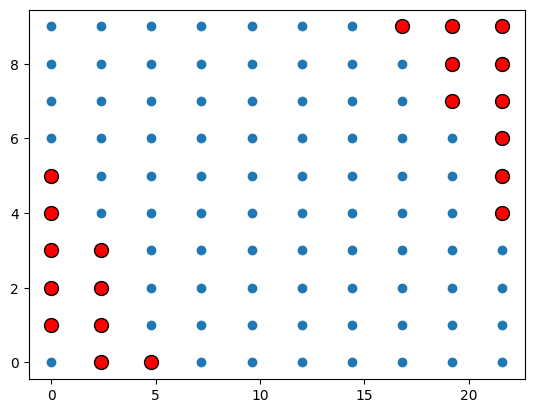

Problem 2 | Cost: 961.572


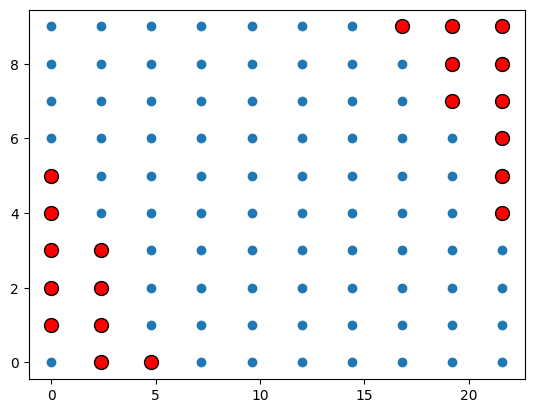

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(2):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions=actions_untrained[i])

In [129]:
trainer = RL4COTrainer(max_epochs=30, devices="auto")
trainer.fit(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | SLAPEnv              | 0      | train
1 | policy   | AttentionModelPolicy | 693 K  | eval 
2 | baseline | WarmupBaseline       | 693 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.550     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [113]:
import torch
from torchrl.data.tensor_specs import DiscreteTensorSpec, BinaryDiscreteTensorSpec, UnboundedContinuousTensorSpec, CompositeSpec
from torchrl.envs.transforms import ActionMask, TransformedEnv
from torchrl.envs.common import EnvBase
from rl4co.models.nn.mlp import MLP

from typing import Tuple, Any, Optional, Union
from tensordict import TensorDict
from rl4co.models.common.constructive.base import NoEncoder
from rl4co.models import ConstructivePolicy

In [114]:
mlp = MLP(input_dim=100, output_dim=100)

In [115]:
td_init

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([3, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        assignment: Tensor(shape=torch.Size([3, 20]), device=cpu, dtype=torch.int32, is_shared=False),
        depot_loc_dist: Tensor(shape=torch.Size([3, 100]), device=cpu, dtype=torch.float32, is_shared=False),
        dist_mat: Tensor(shape=torch.Size([3, 100, 100]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        freq: Tensor(shape=torch.Size([3, 20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        i: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([3, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        picklist: Tensor(shape=torch.Size([3, 20, 5]), device=cpu, dtype=torch.int64, is_shared=False),
        ratio: Tensor(shape=torch.Size([3, 100]), de

In [116]:
from rl4co.utils.ops import calculate_entropy
from rl4co.envs import get_env
from rl4co.utils.decoding import DecodingStrategy, get_decoding_strategy, log, get_log_likelihood


class MLPPolicy(ConstructivePolicy):
    """Template class for an autoregressive policy, simple wrapper around
    :class:`rl4co.models.common.constructive.base.ConstructivePolicy`.

    Note:
        While a decoder is required, an encoder is optional and will be initialized to
        :class:`rl4co.models.common.constructive.autoregressive.encoder.NoEncoder`.
        This can be used in decoder-only models in which at each step actions do not depend on
        previously encoded states.
    """

    def __init__(
        self,
        encoder,
        decoder: MLP,
        env_name: str = "tsp",
        temperature: float = 1.0,
        tanh_clipping: float = 0,
        mask_logits: bool = True,
        train_decode_type: str = "sampling",
        val_decode_type: str = "greedy",
        test_decode_type: str = "greedy",
        **unused_kw,
    ):
        # We raise an error for the user if no decoder was provided
        if decoder is None:
            raise ValueError("MLPPolicy requires a decoder to be provided.")

        super(MLPPolicy, self).__init__(
            encoder=encoder,
            decoder=decoder,
            env_name=env_name,
            temperature=temperature,
            tanh_clipping=tanh_clipping,
            mask_logits=mask_logits,
            train_decode_type=train_decode_type,
            val_decode_type=val_decode_type,
            test_decode_type=test_decode_type,
            **unused_kw,
        )
    
    def pre_decoder_hook(
        self, td: TensorDict, env=None, hidden: Any = None, num_starts: int = 0
    ) -> Tuple[TensorDict, Any]:
        hidden = (hidden,) if not isinstance(hidden, tuple) else hidden

        # if num_starts > 1:
        #     # NOTE: when using pomo, we need this
        #     hidden = tuple(map(lambda x: batchify(x, num_starts), hidden))

        return td, env, hidden
    
    def forward(
        self,
        td: TensorDict,
        env = None,
        phase: str = "train",
        calc_reward: bool = True,
        return_actions: bool = False,
        return_entropy: bool = False,
        return_hidden: bool = False,
        return_init_embeds: bool = False,
        return_sum_log_likelihood: bool = True,
        actions=None,
        max_steps=1_000_000,
        **decoding_kwargs,
    ) -> dict:
        # logits = self.decoder(td["depot_loc_dist"])
        mask = td["action_mask"]
        hidden, init_embeds = self.encoder(td)
        self.num_starts = 0

        # Instantiate environment if needed
        # if isinstance(env, str) or env is None:
        #     env_name = self.env_name if env is None else env
        #     log.info(f"Instantiated environment not provided; instantiating {env_name}")
        #     env = get_env(env_name)

        # Get decode type depending on phase and whether actions are passed for evaluation
        decode_type = decoding_kwargs.pop("decode_type", None)
        if actions is not None:
            decode_type = "evaluate"
        elif decode_type is None:
            decode_type = getattr(self, f"{phase}_decode_type")

        # Setup decoding strategy
        # we pop arguments that are not part of the decoding strategy
        decode_strategy: DecodingStrategy = get_decoding_strategy(
            decode_type,
            temperature=decoding_kwargs.pop("temperature", self.temperature),
            tanh_clipping=decoding_kwargs.pop("tanh_clipping", self.tanh_clipping),
            mask_logits=decoding_kwargs.pop("mask_logits", self.mask_logits),
            store_all_logp=decoding_kwargs.pop("store_all_logp", return_entropy),
            **decoding_kwargs,
        )

        # Pre-decoding hook: used for the initial step(s) of the decoding strategy

        # Additionally call a decoder hook if needed before main decoding

        # Main decoding: loop until all sequences are done
        step = 0
        while not td["done"].all():
            logits = self.decoder(td["depot_loc_dist"])
            td = decode_strategy.step(
                logits,
                mask,
                td,
                action=actions[..., step] if actions is not None else None,
            )
            td = env.step(td)["next"]
            step += 1
            if step > max_steps:
                log.error(
                    f"Exceeded maximum number of steps ({max_steps}) duing decoding"
                )
                break
        # Post-decoding hook: used for the final step(s) of the decoding strategy
        decode_strategy.num_starts = 0
        logprobs, actions, td, env = decode_strategy.post_decoder_hook(td, env)

        # Output dictionary construction
        if calc_reward:
            td.set("reward", env.get_reward(td, actions))

        outdict = {
            "reward": td["reward"],
            "log_likelihood": get_log_likelihood(
                logprobs, actions, td.get("mask", None), return_sum_log_likelihood
            ),
        }

        if return_actions:
            outdict["actions"] = actions
        if return_entropy:
            outdict["entropy"] = calculate_entropy(logprobs)
        if return_hidden:
            outdict["hidden"] = hidden
        if return_init_embeds:
            outdict["init_embeds"] = init_embeds

        return outdict

    

In [207]:
# Import necessary packages
import torch.nn as nn
from torch import Tensor
from tensordict import TensorDict
from typing import Tuple, Union
from rl4co.models.nn.env_embeddings import env_init_embedding


class BaseEncoder(nn.Module):
    def __init__(
            self,
            env_name: str,
            embed_dim: int,
            init_embedding: nn.Module = None,
        ):
        super(BaseEncoder, self).__init__()
        self.env_name = env_name
        
        # Init embedding for each environment
        self.init_embedding = (
            env_init_embedding(self.env_name, {"embed_dim": embed_dim})
            if init_embedding is None
            else init_embedding
        )

    def forward(
        self, td: TensorDict, mask: Union[Tensor, None] = None
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
            td: Input TensorDict containing the environment state
            mask: Mask to apply to the attention

        Returns:
            h: Latent representation of the input
            init_h: Initial embedding of the input
        """
        init_h = self.init_embedding(td)
        h = None
        return init_h, h

In [208]:
emb_dim = 128
base_encoder = BaseEncoder("slap", emb_dim, init_embedding=SLAPInitEmbedding(emb_dim))

In [209]:
from torch import Tensor
from rl4co.models.rl.common.critic import CriticNetwork


class PPOCriticNetwork(nn.Module):
    """Create a critic network given an encoder (e.g. as the one in the policy network)
    with a value head to transform the embeddings to a scalar value.

    Args:
        encoder: Encoder module to encode the input
        value_head: Value head to transform the embeddings to a scalar value
        embed_dim: Dimension of the embeddings of the value head
        hidden_dim: Dimension of the hidden layer of the value head
    """

    def __init__(
        self,
        value_head: Optional[nn.Module] = None,
        embed_dim: int = 128,
        hidden_dim: int = 100,
    ):
        super(PPOCriticNetwork, self).__init__()
        self.encoder = nn.Sequential(
                nn.Linear(100, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, embed_dim)
            )
        if value_head is None:
            # check if embed dim of encoder is different, if so, use it
            value_head = nn.Sequential(
                nn.Linear(embed_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
            )
        self.value_head = value_head

    def forward(self, x: Union[Tensor, TensorDict], hidden=None) -> Tensor:
        """Forward pass of the critic network: encode the imput in embedding space and return the value

        Args:
            x: Input containing the environment state. Can be a Tensor or a TensorDict

        Returns:
            Value of the input state
        """
        h = self.encoder(x["depot_loc_dist"])
        return self.value_head(h).mean(1)  # [batch_size, N] -> [batch_size]

In [210]:
critic = PPOCriticNetwork()

In [211]:
mlppolicy = MLPPolicy(encoder=base_encoder, decoder=mlp)

In [212]:
from rl4co.models import PPO
model = PPO(env, policy=mlppolicy, train_data_size=4,
                       val_data_size=4)

In [213]:
model.critic.encoder(td_init)

(tensor([[[  0.4466,   0.2076,   0.5965,  ...,   0.8847,   0.1810,   0.5060],
          [  0.4012,   0.8650,   0.5903,  ...,   0.1616,   1.0407,   1.0385],
          [  0.3557,   1.5223,   0.5841,  ...,  -0.5616,   1.9004,   1.5710],
          ...,
          [ -0.8524,  19.0086,   0.4196,  ..., -19.7979,  24.7674,  15.7355],
          [ -0.8978,  19.6660,   0.4134,  ..., -20.5211,  25.6271,  16.2680],
          [ -0.9432,  20.3234,   0.4072,  ..., -21.2443,  26.4867,  16.8006]],
 
         [[  0.4466,   0.2076,   0.5965,  ...,   0.8847,   0.1810,   0.5060],
          [  0.4012,   0.8650,   0.5903,  ...,   0.1616,   1.0407,   1.0385],
          [  0.3557,   1.5223,   0.5841,  ...,  -0.5616,   1.9004,   1.5710],
          ...,
          [ -0.8524,  19.0086,   0.4196,  ..., -19.7979,  24.7674,  15.7355],
          [ -0.8978,  19.6660,   0.4134,  ..., -20.5211,  25.6271,  16.2680],
          [ -0.9432,  20.3234,   0.4072,  ..., -21.2443,  26.4867,  16.8006]],
 
         [[  0.4466,   0.207

In [214]:
h, _ = model.critic.encoder(td_init)  # [batch_size, N, embed_dim] -> [batch_size, N]

In [216]:
model.critic.value_head(h).mean(1)


tensor([[-0.2937],
        [-0.2937],
        [-0.2937]], grad_fn=<MeanBackward1>)

In [217]:
trainer = RL4COTrainer(max_epochs=10, devices="auto")
trainer.fit(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Overriding gradient_clip_val to None for 'automatic_optimization=False' models
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name   | Type          | Params | Mode 
-------------------------------------------------
0 | env    | SLAPEnv       | 0      | train
1 | policy | MLPPolicy     | 12.5 K | train
2 | critic | CriticNetwork | 67.2 K | train
-------------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
